## Dependencias

In [ ]:
import numpy as np
import pandas as pd
import re
import os


from collections import Counter
from functools import reduce

import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score

import openpyxl
import xlrd
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de datos de texto

In [ ]:
ruta = '/content/drive/My Drive/deep learning/Opiniones Diplo Concentrado.xlsx'


xl = openpyxl.load_workbook(ruta)

df = pd.concat(map(lambda h:pd.read_excel(ruta,sheet_name=h),xl.sheetnames),ignore_index=True)

In [ ]:
df.shape

(271, 9)

In [ ]:
df.head(2)

,Timestamp,¿Cómo calificas la calidad de los contenidos del curso?,"¿Cómo calificas la calidad de los materiales(apuntes, códigos, datos, etc.?",¿Cómo calificas el nivel de dificultad de los contenidos del curso?,¿Cómo calificas la calidad del ponente?,¿Cómo calificas el nivel de dificultad de la evaluación?,¿Cómo calificas la calidad de las prácticas en clase?,"En general, ¿Cuántas estrellas darías al módulo?","Por favor, emite tu libre opinión sobre el módulo en general (instructor, material, contenido, etc.)"
0,2022-07-28 18:51:17.448,5,5,5,5,5,5,5,"Ponente muy preparado, y nos ayudo a ver que m..."
1,2022-07-28 18:54:47.254,5,5,4,5,3,5,5,El módulo es bastante retador respecto a conte...


## Preprocesamiento

In [ ]:
df = df[['Por favor, emite tu libre opinión sobre el módulo en general (instructor, material, contenido, etc.)',
        'En general, ¿Cuántas estrellas darías al módulo?']]
df.columns = ['texto','sentimiento']

In [ ]:
df.head()

,texto,sentimiento
0,"Ponente muy preparado, y nos ayudo a ver que m...",5
1,El módulo es bastante retador respecto a conte...,5
2,"Me ha encantado mucho este modulo, creo que se...",5
3,Sería de ayuda tener códigos adicionales con m...,5
4,El profesor Oscar es muy bueno. Sabe dar muy b...,5


In [ ]:
df['sentimiento'].describe()

count    271.000000
mean       4.656827
std        0.641425
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: sentimiento, dtype: float64

### Minúsculas

In [ ]:
df['texto'] = df['texto'].map(str.lower)

In [ ]:
df.head()

,texto,sentimiento
0,"ponente muy preparado, y nos ayudo a ver que m...",5
1,el módulo es bastante retador respecto a conte...,5
2,"me ha encantado mucho este modulo, creo que se...",5
3,sería de ayuda tener códigos adicionales con m...,5
4,el profesor oscar es muy bueno. sabe dar muy b...,5


### Quitar stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOP_WORDS = STOP_WORDS.union(set(stopwords.words('spanish')))

In [ ]:
df['texto'] = df['texto'].map(lambda x: [w for w in x.split(' ') if w not in STOP_WORDS]).apply(" ".join)
df.head()

,texto,sentimiento
0,"ponente preparado, ayudo cosas lograr herramie...",5
1,"módulo retador contenidos, goce tiempo clases ...",5
2,"encantado modulo, trabaja optima aprovecha tie...",5
3,ayuda códigos adicionales ejemplos prácticos,5
4,"profesor oscar bueno. clases, ayuda estudiantes.",5


### Lematización (buscar la raíz de la palabra)

In [ ]:
spacy.cli.download("es_core_news_sm")
nlp = spacy.load('es_core_news_sm')

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
df['texto'] = df['texto'].map(nlp).map(lambda x:[w.lemma_ for w in x]).apply(" ".join)
df.head()

,texto,sentimiento
0,"ponente preparado , ayudo cosa lograr herramie...",5
1,"módulo retador contenido , gocir tiempo clás p...",5
2,"encantado modulo , trabajar optimo aprovechar ...",5
3,ayudar código adicional ejemplo práctico,5
4,"profesor oscar bueno . clase , ayuda estudiante .",5


### Quitar puntuación

In [ ]:
"""
re.sub: Patrón, sustitución, texto, juego de caracteres

r' --> Raw String
^ -->  Empieza por..
\w --> alfanuméricos
\s --> espacios
[] --> Incluír solo los caracteres del patrón indicado
"""

df['texto'] = df['texto'].map(lambda x:re.sub(r'[^\w\s]','',x, re.UNICODE))

In [ ]:
df.head()

,texto,sentimiento
0,ponente preparado ayudo cosa lograr herramien...,5
1,módulo retador contenido gocir tiempo clás pa...,5
2,encantado modulo trabajar optimo aprovechar t...,5
3,ayudar código adicional ejemplo práctico,5
4,profesor oscar bueno clase ayuda estudiante,5


### Quitar hapaxes (tokens con frecuencia 1)

In [ ]:
conteos = Counter(reduce(lambda x,y:x+y,df['texto'].map(lambda x:x.split(' '))))

In [ ]:
hapaxes = [t for t,count in conteos.items() if count == 1 or t == '']
df['texto'] = df['texto'].map(lambda x:[w for w in x.split(' ') if w not in hapaxes]).apply(" ".join)
df.head()

,texto,sentimiento
0,ponente preparado ayudo cosa lograr herramienta,5
1,módulo retador contenido tiempo clás pasión pr...,5
2,modulo trabajar aprovechar tiempo dinámica peq...,5
3,ayudar código adicional ejemplo práctico,5
4,profesor oscar bueno clase ayuda,5


## Tokenizar texto en tensores

### Tamaño del vocabulario

In [ ]:
vocab = pd.Series(Counter(reduce(lambda x,y:x+y,df['texto'].map(lambda x:x.split(' '))))).sort_values(ascending=False).to_frame()
vocab.reset_index(inplace=True)
vocab.columns = ['token','count']
vocab['pct'] = vocab['count']/vocab['count'].sum()
vocab.describe()

,count,pct
count,483.000000,483.000000
mean,6.834369,0.002070
std,11.809760,0.003578
min,2.000000,0.000606
25%,2.000000,0.000606
50%,3.000000,0.000909
75%,7.000000,0.002121
max,144.000000,0.043623


### Tokenizar

In [ ]:
tk = tf.keras.preprocessing.text.Tokenizer(num_words=300, lower=True,split=' ')
tk.fit_on_texts(df['texto'])
X = tk.texts_to_sequences(df['texto'])
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(271, 63)

## Variable Objetivo

In [ ]:
df['sentimiento'].value_counts(1).sort_index(ascending=False)

5    0.730627
4    0.210332
3    0.047970
2    0.007380
1    0.003690
Name: sentimiento, dtype: float64

In [ ]:

y = np.array(df['sentimiento']<4).astype(int)

y.mean()

0.05904059040590406

## Partición para entrenamiento

In [ ]:
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.8)
Xt.shape,Xv.shape

((216, 63), (55, 63))

## Configuración entrenamiento

In [ ]:
tam_vocab = len(tk.word_index)
print(tam_vocab)
tam_vector_embed = 10
model = Sequential()
model.add(Embedding(tam_vocab, tam_vector_embed,
                                     input_length=Xt.shape[1]) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',
                           metrics=['accuracy'])
print(model.summary())

480
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 63, 10)            4800      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 63, 10)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,651
Trainable params: 5,651
Non-trainable params: 0
________________________________________________

## Entrenamiento

In [ ]:
historia = model.fit(Xt,yt,
                  validation_split=0.3, epochs=10, batch_size=25,shuffle=True)

Epoch 1/10
7/7 [==============================] - 2s 293ms/step - loss: 0.2282 - accuracy: 0.9404 - val_loss: 0.2799 - val_accuracy: 0.9231
Epoch 2/10
7/7 [==============================] - 2s 292ms/step - loss: 0.2235 - accuracy: 0.9404 - val_loss: 0.2812 - val_accuracy: 0.9231
Epoch 3/10
7/7 [==============================] - 2s 273ms/step - loss: 0.2133 - accuracy: 0.9404 - val_loss: 0.2827 - val_accuracy: 0.9231
Epoch 4/10
7/7 [==============================] - 4s 663ms/step - loss: 0.2201 - accuracy: 0.9404 - val_loss: 0.2840 - val_accuracy: 0.9231
Epoch 5/10
7/7 [==============================] - 2s 294ms/step - loss: 0.2591 - accuracy: 0.9404 - val_loss: 0.2852 - val_accuracy: 0.9231
Epoch 6/10
7/7 [==============================] - 2s 275ms/step - loss: 0.2267 - accuracy: 0.9404 - val_loss: 0.2857 - val_accuracy: 0.9231
Epoch 7/10
7/7 [==============================] - 2s 269ms/step - loss: 0.2425 - accuracy: 0.9404 - val_loss: 0.2849 - val_accuracy: 0.9231
Epoch 8/10
7/7 [====

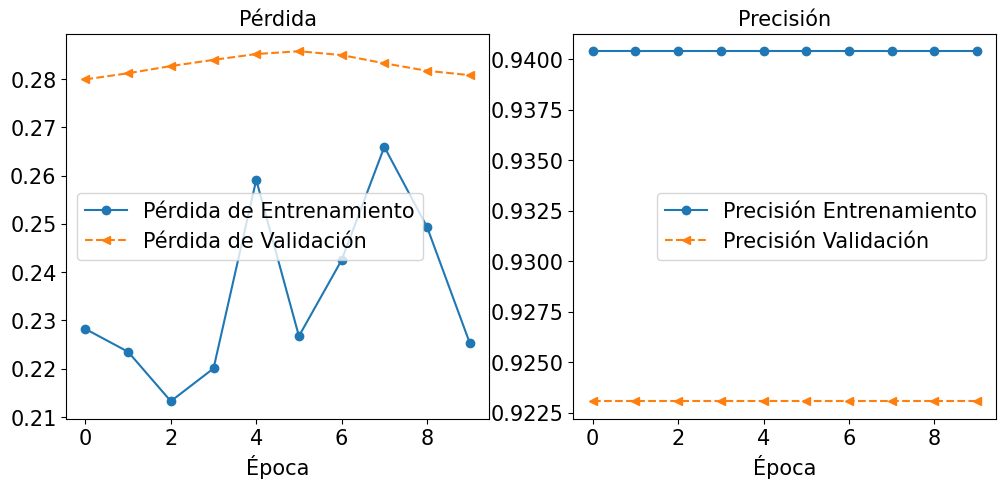

In [ ]:
historia = historia.history
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(historia['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(historia['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(historia['accuracy'],'-o',label='Precisión Entrenamiento')
ax.plot(historia['val_accuracy'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

## Prueba del modelo

In [ ]:
yt_pred = model.predict(Xt)
yt_pred = np.array([int(x[0]>=0.5) for x in yt_pred])
yv_pred = model.predict(Xv)
yv_pred = np.array([int(x[0]>=0.5) for x in yv_pred])

2/2 [==============================] - 0s 22ms/step


In [ ]:
yt_score =np.array([x[0] for x in model.predict(Xt)])
yv_score =np.array([x[0] for x in model.predict(Xv)])

2/2 [==============================] - 0s 38ms/step


In [ ]:
accuracy_score(y_true=yt,y_pred=yt_pred),accuracy_score(y_true=yv,y_pred=yv_pred)

(0.9351851851851852, 0.9636363636363636)

In [ ]:
roc_auc_score(y_true=yt,y_score=yt_score),roc_auc_score(y_true=yv,y_score=yv_score)

(0.8221357850070722, 0.330188679245283)

In [ ]:
for i in range(len(yv)):
    if yv[i] == 1:
        print(tk.sequences_to_texts(Xv)[i],'\t',yv[i],end='\n\n')

docente transmitir conocimiento práctica difícil clase sinceramente gustado aprender módulo 	 1

gustar teoría decir en clase ver tema ir 	 1



In [ ]:
for i in range(len(yt)):
    if yt[i] == 1:
        print(tk.sequences_to_texts(Xt)[i],'\t',yt[i],end='\n\n')

módulo deber tiempo 	 1

general calidad curso buen ponente tema mantener actitud agregar entender tema nota repasar tema 	 1

gusto material tema instructor problema actitud confianza preguntar duda 	 1

profesor nota faltar ejercicio faltar clase 	 1

comentario 	 1

faltar dominio tema faltar tema dominio él tema 	 1

dudar módulo completo embargo seguir él ritmo clase desarrollo código paso paso aplicar teoría código hacer clase tiempo entrega práctico clase yo gustar profesorar dominio tema claro explicar 	 1

profesor cuestión bueno actitud principio seguir conforme avanzar módulo alumno saber 	 1

curso pesado materia instructor impartir excelente 	 1

módulo teórico 	 1

módulo código él 	 1

sentir clase profesor actitud duda quedar transmitir yo gustado material revisar etc diferencia módulo pasado tarea yo gustar actividad retroalimentación mejorar agradecer exponer confianza comprensivo entregar 	 1

profesorar conocimiento notar muchísimo enseñar parecer clase más laboral 